In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
import gzip

%matplotlib inline

# Weights matrix  and biases vector

In [8]:
sizes = [784, 100, 10]

num_layers = len(sizes)

biases = [np.random.randn(y, 1) for y in sizes[1:]]
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

print([w.shape for w in weights], 'and', [b.shape for b in biases])


def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))


def feedforward(a):
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a) + b)
    return a

[(100, 784), (10, 100)] and [(100, 1), (10, 1)]


In [9]:
print([w.shape for w in weights], 'and', [b.shape for b in biases])

[(100, 784), (10, 100)] and [(100, 1), (10, 1)]


In [10]:
inv = np.zeros((784, 1))

res = feedforward(inv)
print(res.shape)

(10, 1)


In [11]:
print(np.array2string(res.reshape((-1,)), separator=', ', formatter={'float_kind': lambda x: f'{x:0.2f}'}))

[0.37, 0.35, 0.00, 0.95, 0.03, 0.99, 0.15, 0.99, 1.00, 0.09]


In [12]:
def load_data():
    with gzip.open('data/mnist.pkl.gz', 'rb') as f:
        train_data, valid_data, test_data = pickle.load(f, encoding='latin1')
    
    return train_data, valid_data, test_data


train_data, valid_data, test_data = load_data()

In [13]:
[t.shape for t in train_data]

[(50000, 784), (50000,)]

In [36]:
x_train, y_train = train_data
x_valid, y_valid = valid_data
x_test, y_test = test_data

In [15]:
y_train

array([5, 0, 4, ..., 8, 4, 8])

In [21]:
def to_categorical(x):
    num_categories = np.unique(x).shape[0]
    vector = np.eye(num_categories, dtype='uint8')[x]
    return vector.reshape((-1, 10, 1))

yy_train = to_categorical(y_train)

In [23]:
yy_train.shape

(50000, 10, 1)

In [24]:
print(yy_train[0], y_train[0])

[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]] 5


In [14]:
x_train.shape

(50000, 784)

In [31]:
xx_train = x_train.reshape((-1, 784, 1))
xx_test = x_test.reshape((-1, 784, 1))

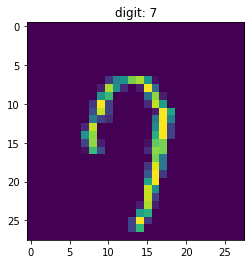

In [25]:
idx = np.random.randint(x_train.shape[0])
plt.imshow(x_train[idx].reshape((28, 28)))
plt.title(f'digit: {y_train[idx]}')
plt.show()

In [27]:
idx = np.random.randint(yy_train.shape[0])

print(yy_train[idx].transpose(), y_train[idx])

[[0 0 0 0 0 1 0 0 0 0]] 5


## SGD
Train the neural network using mini-batch stochastic gradient descent.  The `training_data` is a list of tuples
`(x, y)` representing the training inputs and the desired outputs.  The other non-optional parameters are self-explanatory.  If `test_data` is provided then the network will be evaluated against the test data after each epoch, and partial progress printed out.  This is useful for tracking progress, but slows things down substantially.

## update_mini_batch
Update the network's weights and biases by applying gradient descent using backpropagation to a single mini batch. The `mini_batch` is a list of tuples `(x, y)`, and `eta` is the learning rate.

## backdrop
Return a tuple `(nabla_b, nabla_w)` representing the gradient for the cost function C_x.  `nabla_b` and `nabla_w` are layer-by-layer lists of numpy arrays, similar to `self.biases` and `self.weights`.

In [45]:
def SGD(training_data, epochs, mini_batch_size, eta, test_data=None):
    n = training_data.shape[0]
    
    for j in range(epochs):
        np.random.shuffle(training_data)
        
        mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
        
        for mini_batch in mini_batches:
            update_mini_batch(mini_batch, eta)
            
        if test_data is not None:
            n_test = test_data.shape[0]
            evaluation = evaluate(test_data)
            print(f'Epoch {j:02d}: {evaluation}/{n_test}')
        else:
            print(f'Epoch {j:02d} complete')


def update_mini_batch(mini_batch, eta):
    global biases, weights
    
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]

    for x, y in mini_batch:
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

    n_batch = len(mini_batch)
    
    weights = [w-eta/n_batch*nw for w, nw in zip(weights, nabla_w)]
    biases  = [b-eta/n_batch*nb for b, nb in zip(biases,  nabla_b)]


def backprop(x, y):
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # feed forward
    activation = x
    
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
        
    # backward pass
    
    # cost dericative
    delta = (activations[-1] - y) * sigmoid_prime(zs[-1])
    
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    
    for l in range(2, num_layers):
        delta = np.dot(weights[-l+1].transpose(), delta) * sigmoid_prime(zs[-l])
        
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        
    return nabla_b, nabla_w
        

def sigmoid_prime(z):
    s = sigmoid(z)
    return s * (1 - s)


def evaluate(test_data):
    test_results = [(np.argmax(feedforward(x)), y) for x, y in test_data]
    return sum(int(x == y) for x, y in test_results)

In [32]:
train_input = np.array(list(zip(xx_train, yy_train)))
test_input = np.array(list(zip(xx_test, y_test)))

In [35]:
SGD(train_input, epochs=30, mini_batch_size=10, eta=3.0, test_data=test_input)

Epoch 0: 7727 10000
Epoch 1: 7799 10000
Epoch 2: 7851 10000
Epoch 3: 7816 10000
Epoch 4: 7857 10000
Epoch 5: 7891 10000
Epoch 6: 7904 10000
Epoch 7: 7895 10000
Epoch 8: 7904 10000
Epoch 9: 7902 10000
Epoch 10: 7945 10000
Epoch 11: 7968 10000
Epoch 12: 8003 10000
Epoch 13: 8676 10000
Epoch 14: 8715 10000
Epoch 15: 8709 10000
Epoch 16: 8725 10000
Epoch 17: 8726 10000
Epoch 18: 8736 10000
Epoch 19: 8735 10000
Epoch 20: 8734 10000
Epoch 21: 8743 10000
Epoch 22: 8745 10000
Epoch 23: 8752 10000
Epoch 24: 8754 10000
Epoch 25: 8747 10000
Epoch 26: 8746 10000
Epoch 27: 8746 10000
Epoch 28: 8745 10000
Epoch 29: 8754 10000


In [38]:
evaluate(test_input)

8754

In [37]:
xx_train.shape
y_train.shape

(50000,)

In [46]:
xx_valid = x_valid.reshape((-1, 784, 1))
valid_input = np.array(list(zip(xx_valid, y_valid)))

evaluation = evaluate(valid_input)
num_valid = xx_valid.shape[0]
accuracy = float(evaluation) / num_valid * 100

print(f'Evaluation of the validation dataset: {evaluation}/{num_valid},  accuracy: {accuracy:.2f}%')

Evaluation of the validation dataset: 9678/10000,  accuracy: 96.78%


In [43]:
SGD(train_input, epochs=30, mini_batch_size=10, eta=3.0, test_data=test_input)

Epoch 0: 8746 10000
Epoch 1: 8754 10000
Epoch 2: 8762 10000
Epoch 3: 8767 10000
Epoch 4: 8782 10000
Epoch 5: 8811 10000
Epoch 6: 9608 10000
Epoch 7: 9612 10000
Epoch 8: 9618 10000
Epoch 9: 9626 10000
Epoch 10: 9627 10000
Epoch 11: 9632 10000
Epoch 12: 9657 10000
Epoch 13: 9636 10000
Epoch 14: 9648 10000
Epoch 15: 9649 10000
Epoch 16: 9644 10000
Epoch 17: 9640 10000
Epoch 18: 9640 10000
Epoch 19: 9640 10000
Epoch 20: 9657 10000
Epoch 21: 9635 10000
Epoch 22: 9635 10000
Epoch 23: 9645 10000
Epoch 24: 9648 10000
Epoch 25: 9648 10000
Epoch 26: 9647 10000
Epoch 27: 9647 10000
Epoch 28: 9649 10000
Epoch 29: 9637 10000
